In [253]:
import utils
import numpy as np 
import importlib
import geopandas as gpd
importlib.reload(utils)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'utils' from '/Users/virenbajaj/Desktop/CommercialClusters/utils.py'>

# Commercial Centers of Pittsburgh

In this notebook I will demonstrate how to identify commercial centers of the city of Pittsburgh, PA using Points of Interest aquired from Open Street Maps.

The first step is to answer the question: what is a commercial center?  
As the name suggests, commercial centers are areas of high economic activity. 
These regions have a high density of businesses that partake in buying and selling of goods and services.
These businesses include retail shops, restaurants, bars, cafes, offices, banks, etc. 
People travel to these commmercial centers on a regular basis to conduct all kinds of economic activity, as a result of which they need to encorporate features for the primary mode of transport of the people in the city. 
In Pittsburgh, people mainly travel by car, but it also has decent 'bus-driven' public transport system. 


In our analysis we will look at these major points of interest as indicators for commercial activity, namely:
    1. Restaurants
    2. Bars
    3. Pubs
    4. Cafes
    5. Shops
    6. Offices
    7. Commercial Buildings
    8. Retail Buildings
    9. Bus Stops
    10. Parking

Since there is no way to validate the actual commercial activity of a region, I have chosen a city of which I have 'expert' knowledge, which is to say, I can confirm/reject an area as being commercially active based on past experience. 

The analysis for the collected POI data can be summarized as follows:
    1. Visualize their locations on the map
    2. Identify spatial clusters (regions of high density) of that category of POI 
    3. Calculate how non-random these clusters are using Moran's I Coefficient of Spatial Autocorrelation 
    4. Identify the statistically significant hot-spots of the POIs

Finally, we validate that these are actually commercial centers from expert knowledge. 

### Analyze POIs

Let's import our POI data points from OSM. This can be done by specifying a tuple of primary feature key and sub-feature value. Specifying 'None' as the sub-feature value will select all the sub-feature values. The overall result will be a union of all the individual results.

In [239]:
importlib.reload(utils)
pois = [('amenity','restaurant'),('amenity','bar'),('amenity','pub'),('amenity','cafe'),('amenity','bank'),
        ('shop',None),('office',None),('building','commercial'),('building','retail'),('highway','bus_stop'),
        ('amenity','parking')]
(pois_df,m0,city_boundary_df) = utils.plot_cluster_folium(pois,'pois.osm','pois.geojson',run_query=True)
m0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PGH, Allegheny County, Pennsylvania, USA relation
writing osm data to pois.osm ...
Done.


At the default zoom level we can see the centroids of clusters of the POIs localized to certain parts of the city. The clusters with the maximum number of POIs are most likely in the commercial centers.  

However, how can we quanitfy the significance, or importance of one cluster over another?

Let's split the map into a grid and sum the number of POIs in each cell to get an idea of the density of the clusters. 

Before we can proceed, we need a reasonable value for the dimensions of each grid cell.
To get a hang of the units of areas we're dealing with, let's look at a neighborhood map of Pittsburgh.  
Note: we must project our maps using the universal mercator projection because it prevents any distortion over small regions. Pittsburgh is in zone 17T so we will project it to that zone. This will also convert all the dimensions to meters, making it easier to calculate distances and areas.

In [240]:
neighborhoods= gpd.read_file('geojson/Neighborhoods_.geojson')

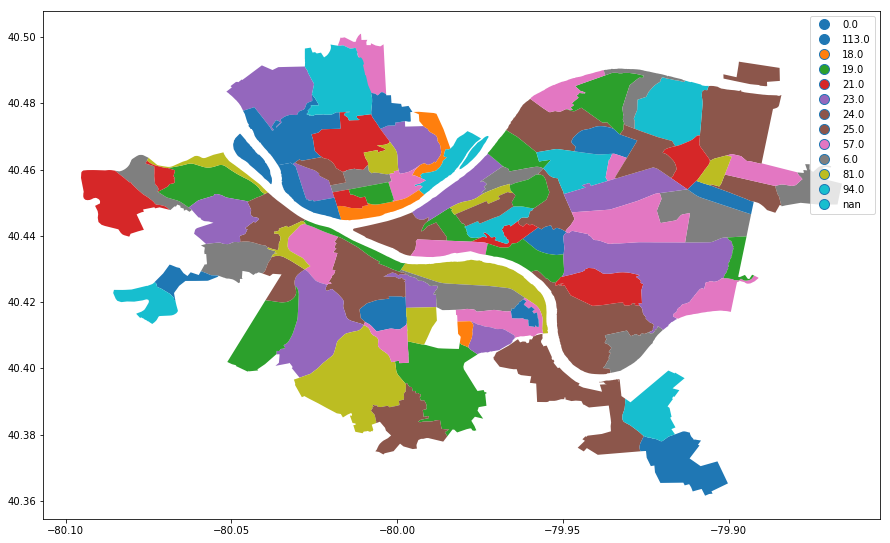

In [241]:
neighborhoods.unique_id = neighborhoods.unique_id.map(str)
neighborhoods.plot(column='unique_id',figsize=(15,15),legend=True)

In [242]:
print(neighborhoods.crs)

{'init': 'epsg:4326'}


In [243]:
neighborhoods.to_crs('+proj=utm +zone=17T +ellps=WGS84 +datum=WGS84 +units=m +no_defs',inplace=True)
print(neighborhoods.crs)
print(f'Average Neighborhood Area is {np.mean(neighborhoods.area)/1000000} km^2') 

+proj=utm +zone=17T +ellps=WGS84 +datum=WGS84 +units=m +no_defs
Average Neighborhood Area is 1.5942433535999854 km^2


Let's split each neighborhood into 10 zones and set the value of the grid size according to that.

In [244]:
height = np.ceil(np.sqrt(np.mean(neighborhoods.area)/10)) 
height # meters

400.0

Now we use this to creat our heat grid.

In [245]:
grid_df,m1 = utils.plot_grid_folium(pois_df,height=height,use_area=False)

In [246]:
m1

What we have generated above is a plot of a two-dimensional histogram with the 'heat' being the number of POIs in each bin. 

TO asses the qulity of the clusters in the this heat map, we use a technique called **Spatial Autocorrelation**.


We use *Moran's I* Coefficient as a measure of spatial autocorellation.  
Its values range from -1 to 1 representing perfect spatial anticorrelation (as in a chess board) and perfect spatial correlation (as in black and white squares of a chess board in separate halves).


Moran's I Coefficient = 0.41568921954859706
p_sim = 0.001
          This is the p-value based on permutations (one-tailed) null: spatial randomness alternative: the 
          observed I is extreme if it is either extremely greater or extremely lower than 
          the values obtained based on permutations


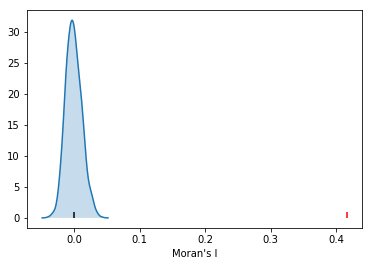

In [247]:
mi = utils.morans_I(grid_df)

The plot above shows us that it is highly unlikely that the the observed clustering is a result of random distribution  
which can be seen is calculated by permuting our points in space and obtainiing a distribution of moran's I.  
We are far above and have a corresponding p-value of 0.001 making these clusters statistically non-random, and there by significant in our analysis.

Next, we look at a queen neighborhood,i.e., all cells that share an edge or vertex with the cell at hand, and assign them weights. This gives us means of quantifying what it means to be a neighbor in a grid.

Next, we look at the spatial lag, which is a measure of similarity of the attribute in each cell, i.e., the 'heat'

In [248]:
spacial_lag_df,m2 = utils.spatial_lag_folium(grid_df)

In [249]:
m2

The analysis above gave us an idea about the global autcorrelation.  

We can also look at the local autocorrelation using local Moran's I.  
This will give us an array of local I statistics instead of a single global one.
Each of these would also have an associated p-value calculated by simulating a different distribution for each location (conditional random permutation).

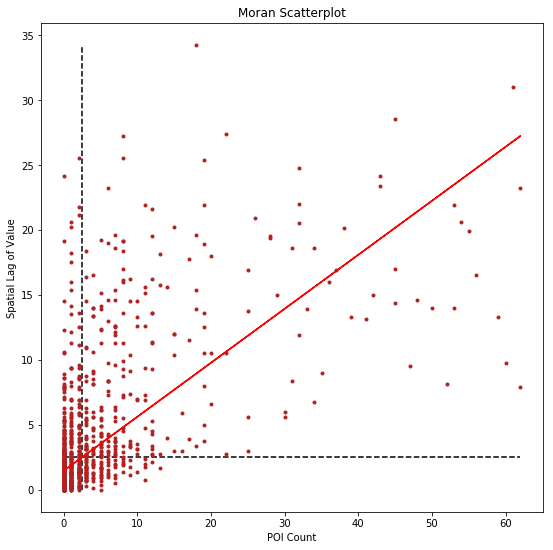

In [250]:
f_moran,ax_moran = utils.moran_scatterplot(grid_df)


We select grids with p-values < 0.003, so that we can identify 'hot spots' which have very high statistical significance. 

In [254]:
hotspot_df,m3 = utils.find_hotspot_folium(grid_df,threshold=0.003)
m3

I have inverted the heat grid so we can peek into what what regions have been identified as hot spots by our analysis.

If you zoom in, you can see grid cells in:
1. Downtown Pittsburgh (https://en.wikipedia.org/wiki/Downtown_Pittsburgh)  
       A typical downtown area with a lot of commercial activity

2. East Carson Street in South Side (https://en.wikipedia.org/wiki/South_Side_(Pittsburgh))  
        Very high density of bars and pubs

3. Oakland  (https://en.wikipedia.org/wiki/Oakland_(Pittsburgh))  
        Home to Univeristy of Pittsburgh and Carnegie Mellon University   
        Lot of college related commercial activity   
    
4. Shady Side  (https://en.wikipedia.org/wiki/Shadyside_(Pittsburgh))  
        Shops and food
    
5. Bloomfield https://en.wikipedia.org/wiki/Bloomfield_(Pittsburgh)  
        Shops and food  
    
5. Murray Avenue in Squirrel Hill https://en.wikipedia.org/wiki/Squirrel_Hill_(Pittsburgh) 
        shope and food 


Finally, we save hotspot information as a shapefile 

In [ ]:
hotspot_df.to_file('poi_hotspots')